# Исследование по RTS

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [534]:
# Загрузка 5 минутных данных
df = pd.read_csv('rts_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
411669,2024-12-30 23:25:00,90630.0,90740.0,90350.0,90390.0,-1,1,-1,-1
411670,2024-12-30 23:30:00,90430.0,90430.0,90380.0,90380.0,-1,-1,-1,-1
411671,2024-12-30 23:35:00,90380.0,90390.0,90280.0,90390.0,-1,-1,-1,-1
411672,2024-12-30 23:40:00,90390.0,90480.0,90390.0,90450.0,-1,1,-1,0


Создание дата фрейма с колонкой **'buy_sell'** признаков открытия позиции Bay или Sell.

In [535]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0,0,0.0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0,0,0.0,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0,0,0.0,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0,0,0.0,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
411669,2024-12-30 23:25:00,90630.0,90740.0,90350.0,90390.0,-1,1,-1,-1,0,0.0,0
411670,2024-12-30 23:30:00,90430.0,90430.0,90380.0,90380.0,-1,-1,-1,-1,0,0.0,0
411671,2024-12-30 23:35:00,90380.0,90390.0,90280.0,90390.0,-1,-1,-1,-1,1,90380.0,-1
411672,2024-12-30 23:40:00,90390.0,90480.0,90390.0,90450.0,-1,1,-1,0,0,0.0,0


Создаем колонку **"profit"** в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [536]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# Результат
df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0,0,0.0,0,0.0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0,0,0.0,0,0.0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0,0,0.0,0,0.0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0,0,0.0,0,0.0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411669,2024-12-30 23:25:00,90630.0,90740.0,90350.0,90390.0,-1,1,-1,-1,0,0.0,0,0.0
411670,2024-12-30 23:30:00,90430.0,90430.0,90380.0,90380.0,-1,-1,-1,-1,0,0.0,0,0.0
411671,2024-12-30 23:35:00,90380.0,90390.0,90280.0,90390.0,-1,-1,-1,-1,1,90380.0,-1,0.0
411672,2024-12-30 23:40:00,90390.0,90480.0,90390.0,90450.0,-1,1,-1,0,0,0.0,0,0.0


Фильтрация

In [537]:
# Очистка df
df = df[df["profit"] != 0.0]

# Фильтрация строк с марта 2015 и времени до 19:00:00
df = df[
    (df["tradedate"] >= pd.Timestamp("2015-03-01")) & 
    (df["tradedate"].dt.time < pd.to_datetime("19:00:00").time())
]

df = df.copy().reset_index(drop=True)

# Добавление колонки с датой
df['date'] = df['tradedate'].dt.date

# Добавление колонки с временем
df['time'] = df['tradedate'].dt.time

# Учет спреда при симуляции торговли
df["profit"] = df["profit"] - 30

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:05:00,89890.0,90030.0,89550.0,89760.0,-1,-1,-1,-1,1,89890.0,-1,-200.0,2015-03-02,10:05:00
1,2015-03-02 11:05:00,90060.0,90220.0,89980.0,90060.0,1,1,1,1,1,90060.0,1,480.0,2015-03-02,11:05:00
2,2015-03-02 12:00:00,90570.0,90580.0,90270.0,90350.0,1,1,1,1,1,90570.0,1,-480.0,2015-03-02,12:00:00
3,2015-03-02 13:45:00,90120.0,90200.0,90070.0,90140.0,-1,-1,-1,-1,1,90120.0,-1,190.0,2015-03-02,13:45:00
4,2015-03-02 14:30:00,89900.0,89930.0,89530.0,89670.0,-1,-1,-1,-1,1,89900.0,-1,20.0,2015-03-02,14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23491,2024-12-30 14:15:00,89690.0,89920.0,89660.0,89880.0,1,1,1,1,1,89690.0,1,-50.0,2024-12-30,14:15:00
23492,2024-12-30 15:40:00,89670.0,89840.0,89600.0,89790.0,-1,-1,-1,-1,1,89670.0,-1,-290.0,2024-12-30,15:40:00
23493,2024-12-30 15:55:00,89930.0,90000.0,89820.0,89830.0,-1,-1,-1,-1,1,89930.0,-1,170.0,2024-12-30,15:55:00
23494,2024-12-30 17:00:00,89730.0,90090.0,89710.0,90090.0,1,1,1,1,1,89730.0,1,330.0,2024-12-30,17:00:00


In [538]:
print(f'Средний профит на сделку: {df['profit'].mean().round(2)}')

Средний профит на сделку: 30.74


Создание DF с профитом по времени открытия сделок.

In [539]:
df_time = (
    df.groupby(['time'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_profit=('profit', 'count')  # Количество значений profit
    )
    .sort_values(['total_profit'], ascending=False)
)

df_time['profit_avg'] = df_time['total_profit'] / df_time['count_profit']

df_time['profit_avg'] = df_time['profit_avg'].round(2)

print(df_time.sort_values (by='profit_avg', ascending=False).head(20))

         time  total_profit  count_profit  profit_avg
0    07:00:00       48080.0            52      924.62
36   10:00:00      133090.0           277      480.47
41   10:25:00       25610.0           140      182.93
126  17:30:00       34110.0           211      161.66
24   09:00:00       11810.0            85      138.94
21   08:45:00        2430.0            20      121.50
62   12:10:00       25680.0           222      115.68
64   12:20:00       22580.0           198      114.04
38   10:10:00       28620.0           255      112.24
15   08:15:00        1120.0            10      112.00
123  17:15:00       21170.0           214       98.93
54   11:30:00       17550.0           182       96.43
132  18:00:00       17950.0           197       91.12
131  17:55:00       19080.0           220       86.73
111  16:15:00       18130.0           228       79.52
74   13:10:00       18280.0           243       75.23
121  17:05:00       17480.0           235       74.38
6    07:30:00         370.0 

In [540]:
# # Сохранение в файл
# df_time.sort_values(by='time', ascending=True).to_excel('GMTS_исследования_времени_торговли.xlsx')

Создание графика со средними значениями профита

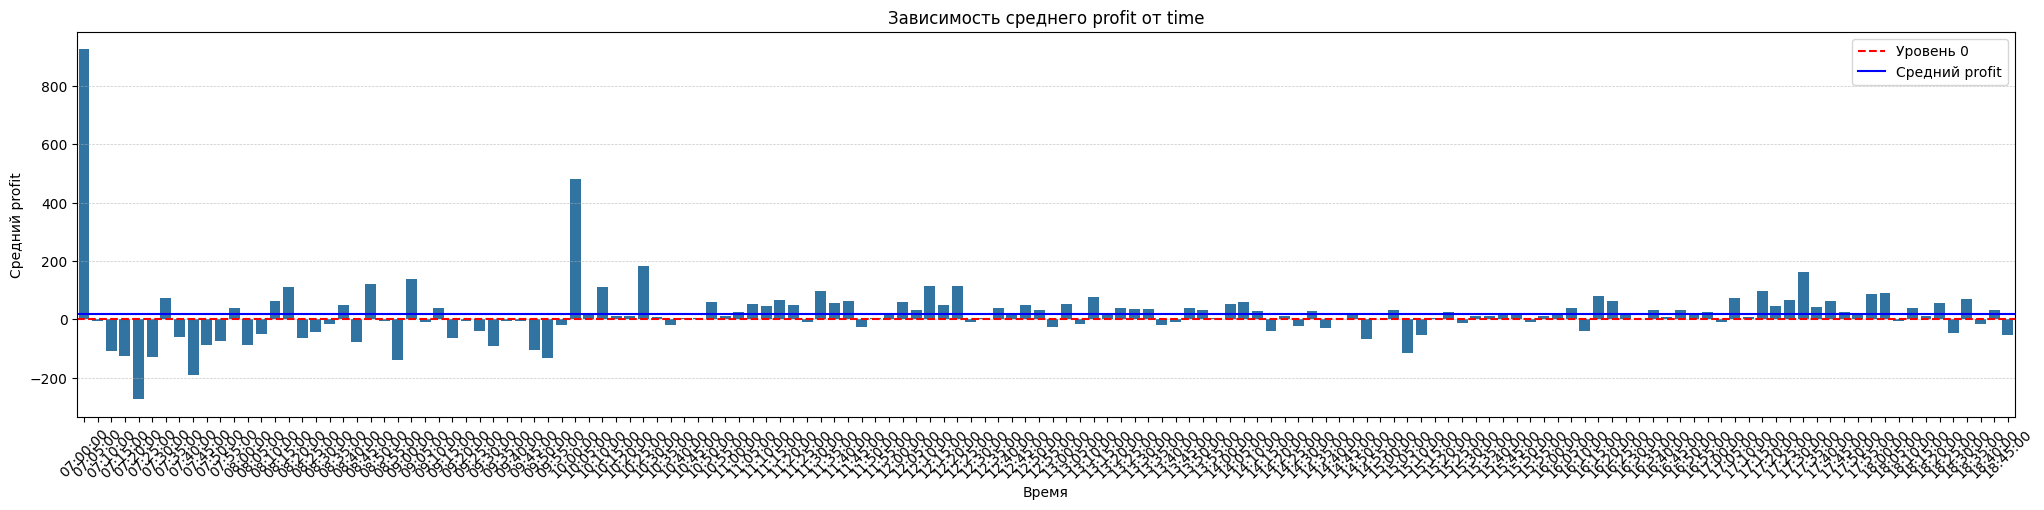

In [541]:
df_time = df_time.sort_values(by='time', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_time['time'].astype(str), y=df_time['profit_avg'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_time['profit_avg'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

# Настройки графика
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость среднего profit от time')
plt.xlabel('Время')
plt.ylabel('Средний profit')
plt.legend()  # Добавляем легенду
plt.show()

# Прибыль по сделкам за 15:15-18:20

In [542]:
# Фильтрация строк с 15:15:00
df_amer = df[
         (df["tradedate"].dt.time >= pd.to_datetime("15:15:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:20:00").time())
]

df_amer

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
5,2015-03-02 16:25:00,89850.0,90030.0,89840.0,89900.0,1,1,1,1,1,89850.0,1,180.0,2015-03-02,16:25:00
6,2015-03-02 17:45:00,90060.0,90190.0,89960.0,90010.0,1,1,1,1,1,90060.0,1,-230.0,2015-03-02,17:45:00
13,2015-03-03 15:20:00,92110.0,92280.0,92060.0,92190.0,1,1,1,1,1,92110.0,1,-390.0,2015-03-03,15:20:00
14,2015-03-03 15:40:00,91750.0,91760.0,91630.0,91670.0,-1,-1,-1,-1,1,91750.0,-1,230.0,2015-03-03,15:40:00
15,2015-03-03 17:20:00,91490.0,91690.0,91440.0,91680.0,1,1,1,1,1,91490.0,1,-360.0,2015-03-03,17:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23487,2024-12-28 18:20:00,88490.0,88580.0,88470.0,88470.0,-1,-1,-1,-1,1,88490.0,-1,-200.0,2024-12-28,18:20:00
23492,2024-12-30 15:40:00,89670.0,89840.0,89600.0,89790.0,-1,-1,-1,-1,1,89670.0,-1,-290.0,2024-12-30,15:40:00
23493,2024-12-30 15:55:00,89930.0,90000.0,89820.0,89830.0,-1,-1,-1,-1,1,89930.0,-1,170.0,2024-12-30,15:55:00
23494,2024-12-30 17:00:00,89730.0,90090.0,89710.0,90090.0,1,1,1,1,1,89730.0,1,330.0,2024-12-30,17:00:00


In [543]:
# Средний профит на сделку
print(f'Средний профит на сделку за 15:15-18:20: {df_amer['profit'].mean().round(2)}')

Средний профит на сделку за 15:15-18:20: 32.71


### Прибыль по дням  за 15:15-18:20

In [544]:
df_amer_date = (
    df_amer.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_amer_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

# Добавляем новую колонку для среднего профита на сделку
df_amer_date['avg_profit_per_trade'] = df_amer_date['total_profit'] / df_amer_date['count_trade']
avg_profit_per_trade = df_amer_date['avg_profit_per_trade'].mean().round(2)

df_amer_date

,date,total_profit,count_trade,avg_profit_per_trade
0,2015-03-02,-50.0,2,-25.000000
1,2015-03-03,-840.0,4,-210.000000
2,2015-03-04,1620.0,4,405.000000
3,2015-03-05,-1070.0,4,-267.500000
4,2015-03-06,2000.0,3,666.666667
...,...,...,...,...
2449,2024-12-25,-360.0,5,-72.000000
2450,2024-12-26,-330.0,3,-110.000000
2451,2024-12-27,20.0,3,6.666667
2452,2024-12-28,-130.0,4,-32.500000


### Прибыль по месяцам за 15:15-18:20

In [545]:
df_tmp = df_amer.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df_tmp['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,6270.0,63,125.4
1,2015-04,6600.0,72,132.0
2,2015-05,11480.0,59,229.6
3,2015-06,8860.0,69,177.2
4,2015-07,1560.0,78,31.2
...,...,...,...,...
113,2024-08,240.0,71,4.8
114,2024-09,2600.0,69,52.0
115,2024-10,1250.0,81,25.0
116,2024-11,6780.0,62,135.6


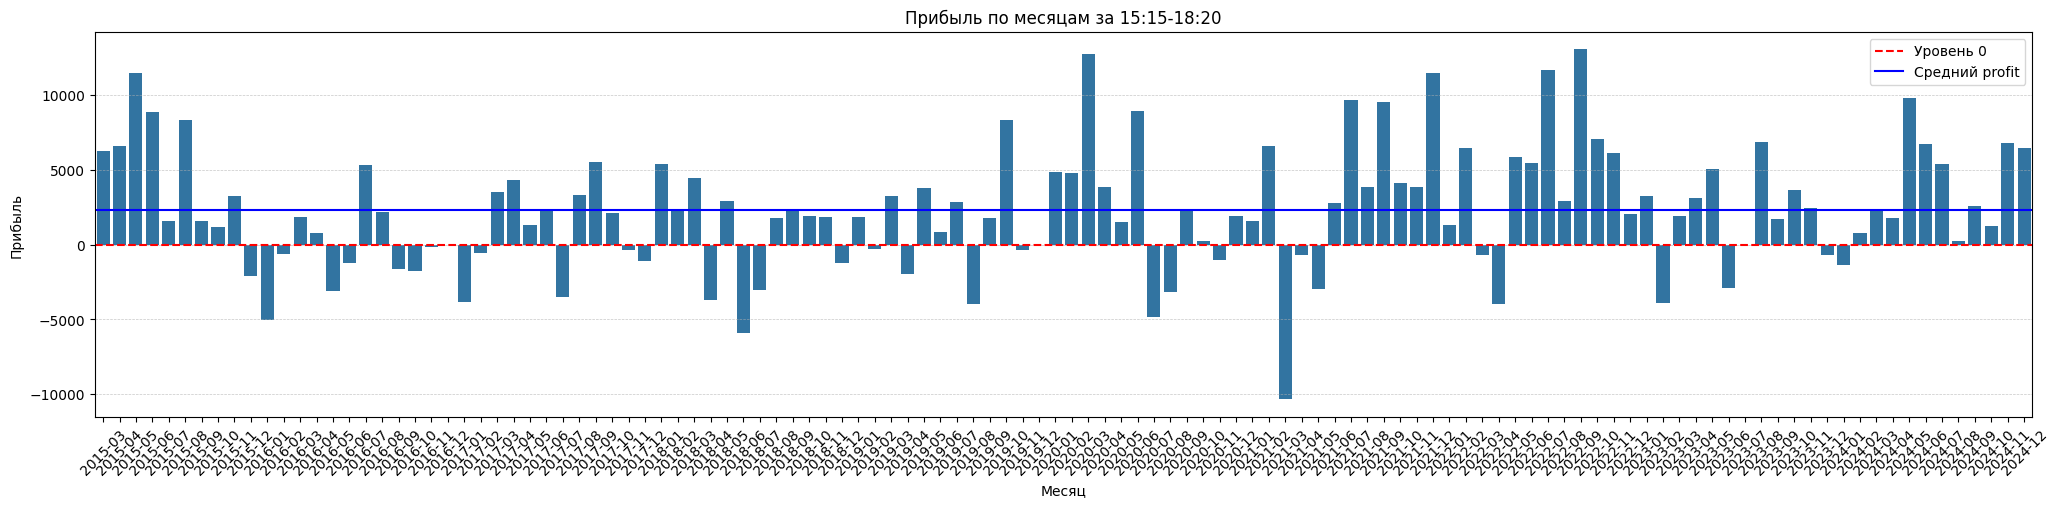

In [546]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Прибыль по месяцам за 15:15-18:20')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.legend()  # Добавляем легенду
plt.show()

### График комулятивной прибыли за 15:15-18:20

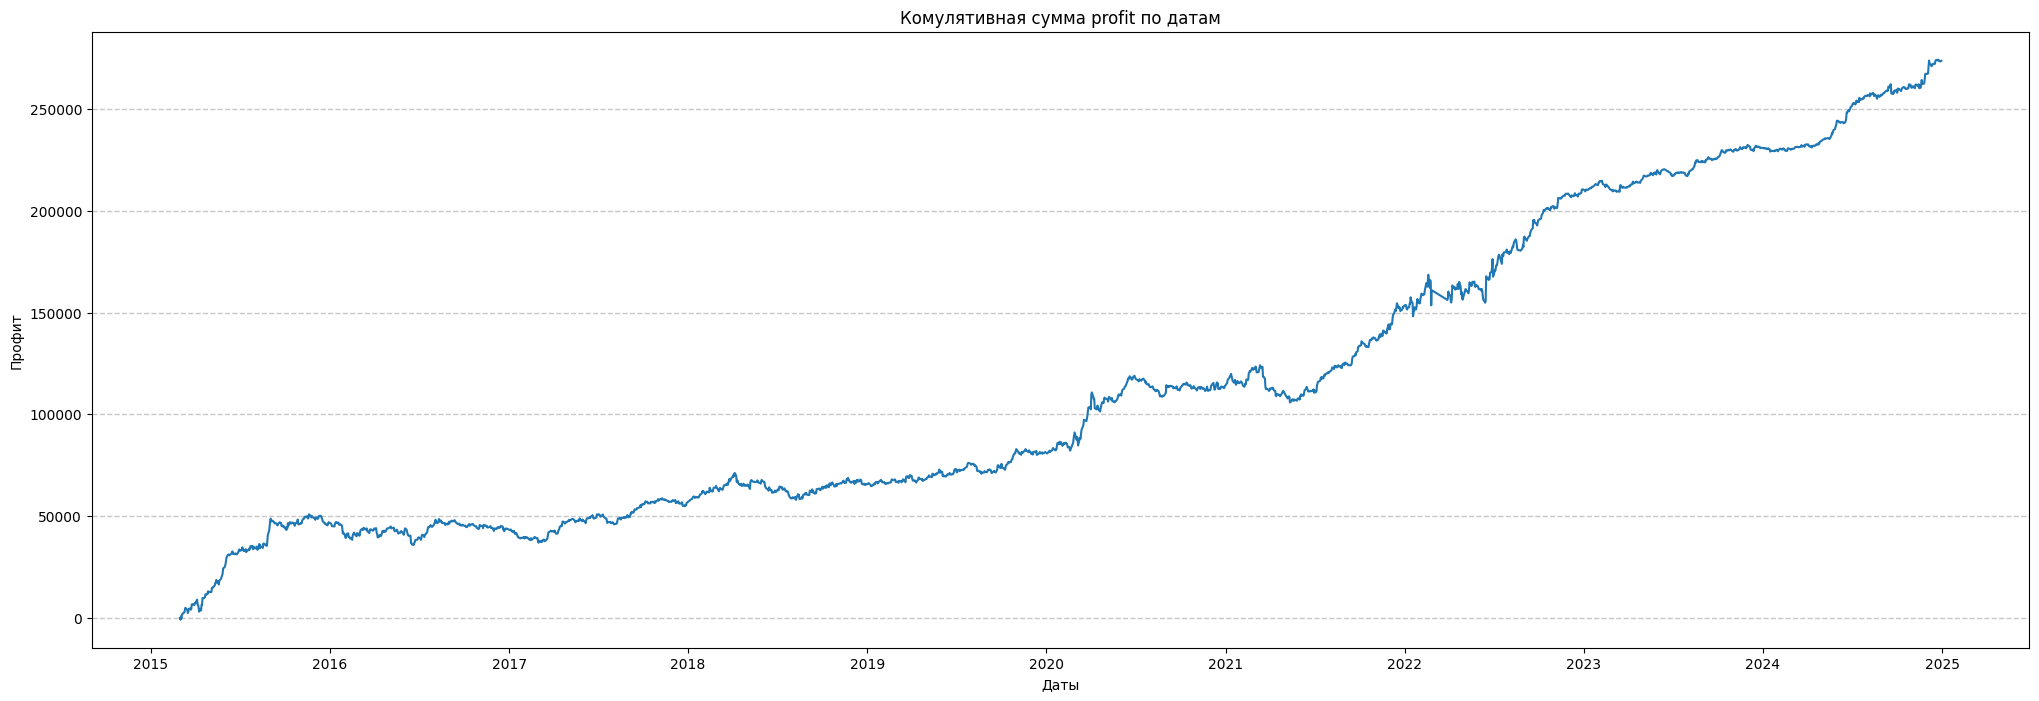

In [547]:
df_amer_date['sum_profit'] = df_amer_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_amer_date, x=df_amer_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.grid(axis='y', linestyle='--', linewidth=1.0, alpha=0.7)  # Только по оси Y
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()

# Прибыль за две сессии 10:05-14:10 и 15:15-18:30

In [548]:
# Фильтрация строк
df_2 = df[
         (df["tradedate"].dt.time >= pd.to_datetime("10:05:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("14:10:00").time()) |
         (df["tradedate"].dt.time >= pd.to_datetime("15:15:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:30:00").time())
]

df_2

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:05:00,89890.0,90030.0,89550.0,89760.0,-1,-1,-1,-1,1,89890.0,-1,-200.0,2015-03-02,10:05:00
1,2015-03-02 11:05:00,90060.0,90220.0,89980.0,90060.0,1,1,1,1,1,90060.0,1,480.0,2015-03-02,11:05:00
2,2015-03-02 12:00:00,90570.0,90580.0,90270.0,90350.0,1,1,1,1,1,90570.0,1,-480.0,2015-03-02,12:00:00
3,2015-03-02 13:45:00,90120.0,90200.0,90070.0,90140.0,-1,-1,-1,-1,1,90120.0,-1,190.0,2015-03-02,13:45:00
5,2015-03-02 16:25:00,89850.0,90030.0,89840.0,89900.0,1,1,1,1,1,89850.0,1,180.0,2015-03-02,16:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23490,2024-12-30 13:05:00,89400.0,89500.0,89360.0,89480.0,-1,-1,-1,-1,1,89400.0,-1,-320.0,2024-12-30,13:05:00
23492,2024-12-30 15:40:00,89670.0,89840.0,89600.0,89790.0,-1,-1,-1,-1,1,89670.0,-1,-290.0,2024-12-30,15:40:00
23493,2024-12-30 15:55:00,89930.0,90000.0,89820.0,89830.0,-1,-1,-1,-1,1,89930.0,-1,170.0,2024-12-30,15:55:00
23494,2024-12-30 17:00:00,89730.0,90090.0,89710.0,90090.0,1,1,1,1,1,89730.0,1,330.0,2024-12-30,17:00:00


In [549]:
# Средний профит на сделку
print(f'Средний профит на сделку 10:05-14:10 и 15:15-18:20: {df_2['profit'].mean().round(2)}')

Средний профит на сделку 10:05-14:10 и 15:15-18:20: 33.04


### Прибыль по дням за 2 сессии 10:05-14:10 и 15:15-18:30

In [550]:
df_2_date = (
    df_2.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_2_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

# Добавляем новую колонку для среднего профита на сделку
df_2_date['avg_profit_per_trade'] = df_2_date['total_profit'] / df_2_date['count_trade']
avg_profit_per_trade = df_2_date['avg_profit_per_trade'].mean().round(2)

df_2_date


,date,total_profit,count_trade,avg_profit_per_trade
0,2015-03-02,-60.0,6,-10.000000
1,2015-03-03,700.0,7,100.000000
2,2015-03-04,1440.0,8,180.000000
3,2015-03-05,780.0,10,78.000000
4,2015-03-06,2430.0,7,347.142857
...,...,...,...,...
2466,2024-12-25,330.0,7,47.142857
2467,2024-12-26,-970.0,7,-138.571429
2468,2024-12-27,760.0,6,126.666667
2469,2024-12-28,270.0,9,30.000000


### Прибыль по месяцам за две сессии 10:05-14:10 и 15:15-18:30

In [551]:
df_tmp = df_tmp.iloc[0:0]
df_month_profit = df_month_profit.iloc[0:0]

df_tmp = df_2.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,9940.0,159,198.8
1,2015-04,19420.0,163,388.4
2,2015-05,5230.0,135,104.6
3,2015-06,12300.0,158,246.0
4,2015-07,270.0,178,5.4
...,...,...,...,...
113,2024-08,4450.0,166,89.0
114,2024-09,2650.0,169,53.0
115,2024-10,3850.0,178,77.0
116,2024-11,9160.0,157,183.2


In [552]:
# Средний профит в день в долларах
print(f'Средний профит в день в долларах: {df_month_profit['dollar'].mean().round(2)}')

Средний профит в день в долларах: 105.57


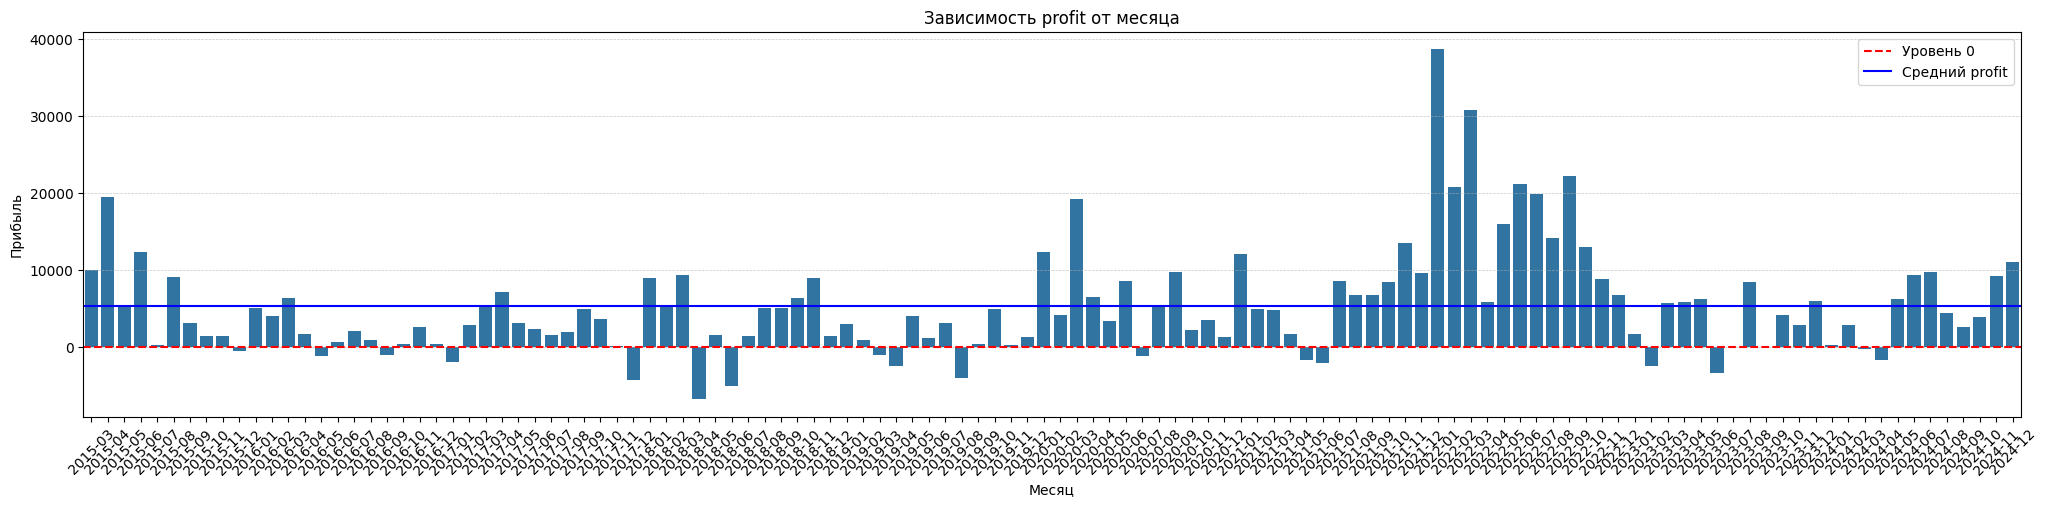

In [553]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость profit от месяца')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.legend()  # Добавляем легенду
plt.show()

### График комулятивной прибыли для 2 сессий 10:05-14:10 и 15:15-18:30

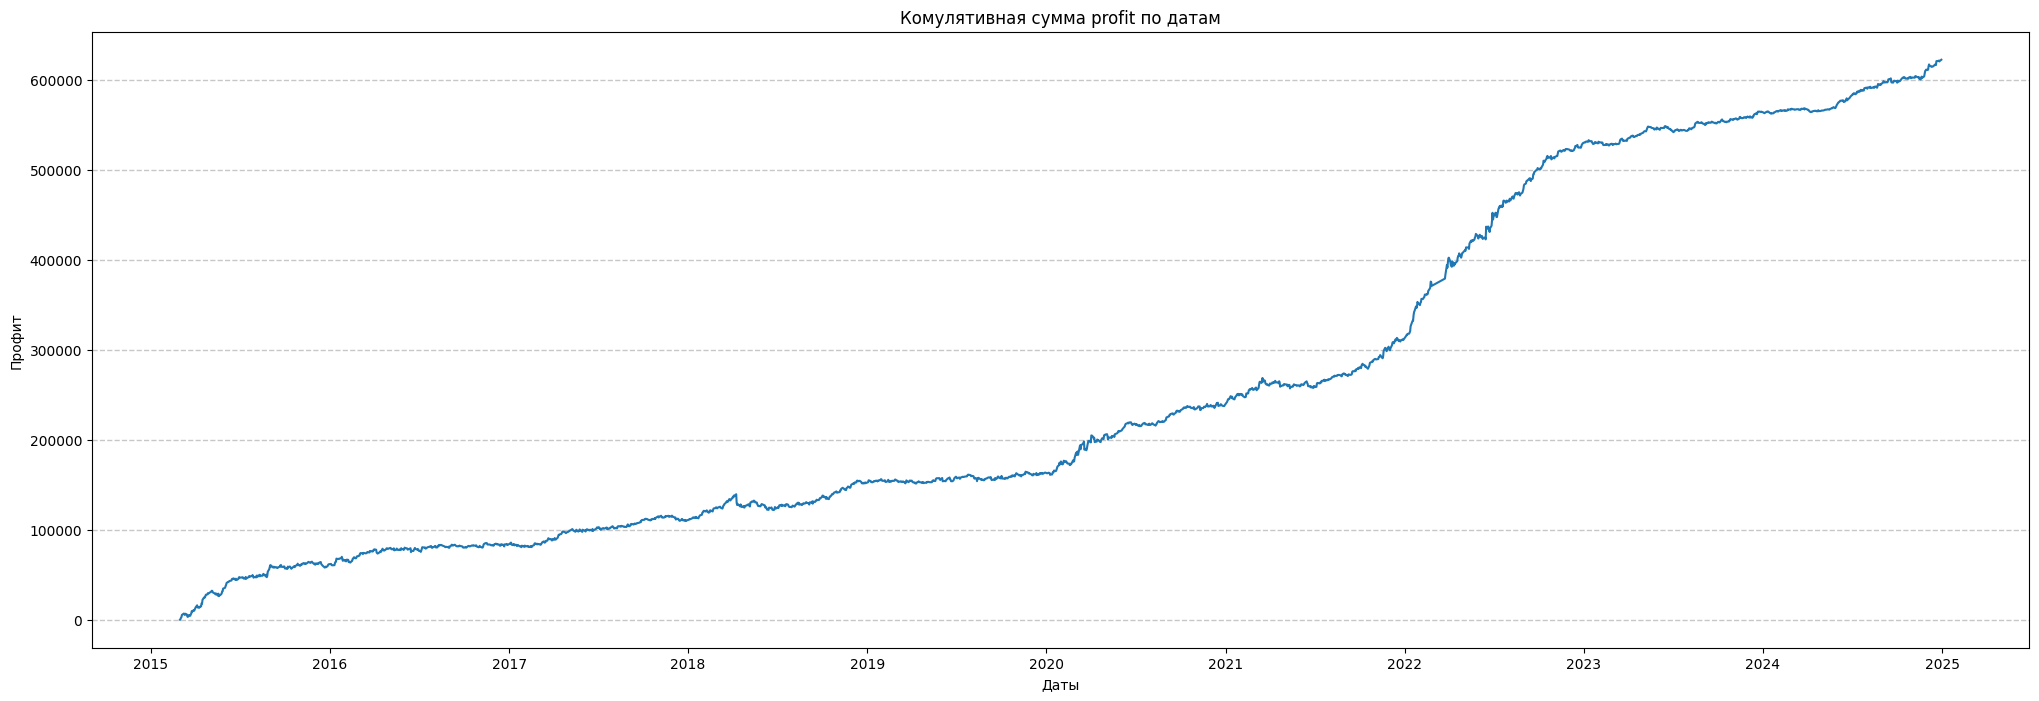

In [554]:
df_2_date['sum_profit'] = df_2_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_2_date, x=df_2_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.grid(axis='y', linestyle='--', linewidth=1.0, alpha=0.7)  # Только по оси Y
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()

In [555]:
df_tmp = df_tmp.iloc[0:0]

df_tmp = df_2.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df['date'])

# Добавляем колонки для года и месяца
df_tmp['year'] = df_tmp['date'].dt.to_period('Y')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_year_profit = (
    df_tmp.groupby('year')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

df_year_profit['dollar'] = df_year_profit['total_profit'] * 0.02

df_year_profit

,year,total_profit,total_trades,dollar
0,2015,61610.0,1613,1232.2
1,2016,21890.0,1936,437.8
2,2017,26840.0,1885,536.8
3,2018,41510.0,1905,830.2
4,2019,11820.0,1936,236.4
5,2020,74910.0,1827,1498.2
6,2021,73270.0,2007,1465.4
7,2022,218110.0,1861,4362.2
8,2023,35140.0,1923,702.8
9,2024,57740.0,1960,1154.8
